Nozomu Nakanishi - 2020264 - Msc DA

# The objectives here are:

## - To create neural networks, at least two and  compare their performance and evaluate what one performed better by using loss as primary and accuracy as the second metrics.

## - Sentiment Analysis using peoples review about culinary recipes on food.com. 

### The reviews a dataset with the score given in stars (from 0/1 to 5) along with the written review. (features that are going to be used.

### Positive / Negative / Neutral Sentimet on the recipes review. 

In [1]:
# The command below is to check where the PySpark is running, 
# in this case (returned:local[*]) data is being processed on my local (personal) machine.

sc.master

'local[*]'

# START ADDING ALL THE LIBRARIES HERE.

In [2]:
from pyspark.sql.functions import count # Funcion to get the "size" of the data.
from pyspark.sql.functions import when # When function.
from pyspark.sql.functions import col # Function column.
from pyspark.sql.functions import mean, min, max, stddev # Imports function for statistical features. 
from pyspark.sql import functions as F # Data processing framework.
from pyspark.sql.functions import lower # lower case function.
from pyspark.sql.functions import length # Import lenght function.
from pyspark.sql.functions import size, split # Imports function size and split.
from pyspark.ml.feature import Tokenizer # Importing Tokenizer.
from pyspark.sql.functions import regexp_replace # Remove / Replace function.
from pyspark.sql.functions import explode, count, desc # Importing for word count.
from pyspark.ml.feature import StopWordsRemover # Imports stopword remover.
from pyspark.sql.types import StructField, StructType # Importing features for Schema.
from pyspark.sql.types import IntegerType, StringType, TimestampType # Tools to create the schema.
from pyspark.sql.functions import udf # Imports function UDF.
from pyspark.sql.types import ArrayType, StringType
import numpy as np # for numerical operations.
import seaborn as sns # Visualization tool.
import matplotlib.pyplot as plt # visualization
%matplotlib inline 

import warnings # Ignore warnings.
warnings.filterwarnings("ignore")

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
spark = SparkSession.builder.appName('recipe_reviews').getOrCreate()

- The process to achieve the objetive will start importing the recipes reviews dataset and it is composed by 8 features and more than a million rows. The dataset is lincesed under the Creative Commons (CC0 1.0 DEED).

The link for the dataset is available at kaggle: https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews

- There are two datasets in the zip file, however it does not says that the recipe ID in one will match the recipe ID in the other, therefore using only the reviews dataset to achieve the objective.<br>
- Also, two types of format is available, a parquet file and a csv files and the choice for the first one is that the parquet file already has a columnar type, which when taking into consideration the tools that are being used such as pyspark it will present a better speed perfomance when performing tasks. In addition to the reduction for its size in megabytes. 
- The dataset review, which is going to be manipulated, is regarding the written reviews along with score rating given. <b>They are the most important features in  the dataset, in which the rating score would define the positive, neutral and negative label for the sentiment analysis of the review. </b>

## 1. Data preparation and EDA
- Challeging to separete, both will be performed back and forth. 

### - Importing the Review dataset.

First, the dataset will be imported in parquet format as cited above.

In [4]:
# Imports the dataset in a parquet format.
df_reviews = spark.read.parquet("file:///home/hduser/Downloads/Dataset CA1/reviews.parquet")

- After applying .head and .show, the second presented a better layout to look at the columns and the first 10 rows.

In [5]:
# It shows the first ten observations.
df_reviews.show(10)

+--------+--------+--------+----------------+------+--------------------+-------------------+-------------------+
|ReviewId|RecipeId|AuthorId|      AuthorName|Rating|              Review|      DateSubmitted|       DateModified|
+--------+--------+--------+----------------+------+--------------------+-------------------+-------------------+
|       2|     992|    2008|       gayg msft|     5|better than any y...|2000-01-25 21:44:00|2000-01-25 21:44:00|
|       7|    4384|    1634|   Bill Hilbrich|     4|I cut back on the...|2001-10-17 17:49:59|2001-10-17 17:49:59|
|       9|    4523|    2046|Gay Gilmore ckpt|     2|i think i did som...|2000-02-25 09:00:00|2000-02-25 09:00:00|
|      13|    7435|    1773|   Malarkey Test|     5|easily the best i...|2000-03-13 21:15:00|2000-03-13 21:15:00|
|      14|      44|    2085|      Tony Small|     5|  An excellent dish.|2000-03-28 13:51:00|2000-03-28 13:51:00|
|      17|    5221|    2046|Gay Gilmore ckpt|     4|love it, but with...|2000-05-08 12:0

In [6]:
# Prints the Schema of the dataset.
df_reviews.printSchema()

root
 |-- ReviewId: integer (nullable = true)
 |-- RecipeId: integer (nullable = true)
 |-- AuthorId: integer (nullable = true)
 |-- AuthorName: string (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Review: string (nullable = true)
 |-- DateSubmitted: timestamp (nullable = true)
 |-- DateModified: timestamp (nullable = true)



- The parquet format file already had a schema, therefore keeping the original dataset schema. However, if the csv were to be handled the following code would be appropriate to apply the schema, including the column names along with the data type.

In [7]:
# Code that would be used to apply the schema in the review dataset if was required.

#schema_reviews = StructType([
    #StructField('ReviewId', IntegerType(), True),
    #StructField('RecipeId', IntegerType(), True),
    #StructField('AuthorId', IntegerType(), True),
    #StructField('AuthorName', StringType(), True),
    #StructField('Rating', IntegerType(), True),
    #StructField('Review', StringType(), True),
    #StructField('DateSubmitted', TimestampType(), True),
    #StructField('DateModified', TimestampType(), True)])

The library Pandas used in the previous semester had different set of functions and/or commands. For example, the shape which provided the number of columns and observations in the dataset. However, in the PySpark the count method is use to tell how many rows and the lenght of the columns for the number of features. 
<br>However, in a later stage pandas format will be used for visualization purpose only, because pandas visualizations are better than the pyspark.

In [8]:
num_rows_reviews = df_reviews.count() # Counting the number of rows.
num_columns_reviews =len(df_reviews.columns) # Length of columns.
print(f"Shape: ({num_rows_reviews}, {num_columns_reviews})") # Prints the shape of the dataset.

Shape: (1401982, 8)


- Temporal analysis is not the focus of the project, therefore, the date submitted and modified will be dropped in an early stage.

In [9]:
# Droping two columns of the dataset.
df_reviews = df_reviews.drop("DateSubmitted", "DateModified")

In [10]:
# The three codes below are searching and printing the number of missing values in Review, Rating, Recipe Id.

missing_review = df_reviews.filter(df_reviews.Review.isNull())
print(f"Number of observations with missing Review: {missing_review.count()}")

missing_rating = df_reviews.filter(df_reviews.Rating.isNull())
print(f"Number of observations with missing Rating: {missing_rating.count()}")

missing_recipeid = df_reviews.filter(df_reviews.RecipeId.isNull())
print(f"Number of observations with missing Recipe Id: {missing_recipeid.count()}")

Number of observations with missing Review: 0
Number of observations with missing Rating: 0
Number of observations with missing Recipe Id: 0


- No missing values are recorded in the Recipe Id and Review, Ratings.

Regarding the frequency, three features will be analysed, the Rating scores (check which score have the highest number and the lowest), the RecipeId (check how many times that recipe recieved a review and the AuthorId (check how many times that author wrote a review).

In [11]:
# The codes below are getting the frequency of values using the count function and printing them from
# the highest to the lowest.

df_reviews.groupBy("Rating").count().orderBy("Rating").show()
print(f"Frequency of Ratings")

df_reviews.groupBy("RecipeId").count().orderBy("count", ascending=False).show(20)
print(f"Frequency of RecipesId")

df_reviews.groupBy("AuthorId").count().orderBy("count", ascending=False).show(20)
print(f"Frequency of AuthorId")

+------+-------+
|Rating|  count|
+------+-------+
|     0|  76248|
|     1|  16559|
|     2|  17597|
|     3|  50279|
|     4| 229217|
|     5|1012082|
+------+-------+

Frequency of Ratings


+--------+-----+
|RecipeId|count|
+--------+-----+
|   45809| 2892|
|    2886| 2182|
|   27208| 1614|
|   89204| 1584|
|   39087| 1491|
|   67256| 1359|
|   35813| 1353|
|   54257| 1325|
|   22782| 1273|
|   32204| 1228|
|  420398| 1174|
|   25690| 1076|
|   69173| 1023|
|   73440| 1008|
|   68955|  910|
|   33919|  885|
|   82102|  862|
|   25885|  856|
|   85629|  805|
|   28148|  804|
+--------+-----+
only showing top 20 rows

Frequency of RecipesId


+--------+-----+
|AuthorId|count|
+--------+-----+
|  424680| 8842|
|   37449| 6605|
|  383346| 5438|
|  128473| 4693|
|  169430| 4586|
|   89831| 3963|
|   58104| 3743|
|  199848| 3688|
|  133174| 3590|
|  305531| 3543|
|  226863| 3340|
|    4470| 3260|
|  369715| 3167|
|  498271| 3014|
| 1072593| 2810|
|  176615| 2790|
|   95743| 2664|
|  286566| 2635|
|  107583| 2588|
|   88099| 2574|
+--------+-----+
only showing top 20 rows

Frequency of AuthorId


The Recipes and AuthorId column:
- The recipes that recieved the highest amount of reviews was with the ID of 45089 and 2886 (more than 2000 ratings);
- The Author that most reviewed recipes on the website was the Id424680 with 8842, followed by Id37449 with 6605 reviews;

In [12]:
# Checking if the same user (AuthorId) posted more than one review in a recipe (RecipeId).
# Since both columns are integers, the group by and aggregation will be used to find it.

# Grouping the Author and Recipe Id and count the occurrences.
dd_review = df_reviews.groupBy("AuthorId", "RecipeId").agg(F.count("*").alias("num_reviews"))
# Filtering rows where the count is above 1, which can indicate that the recipe multiple review from the same user.
dd_review = dd_review.filter(dd_review.num_reviews > 1)
# Displaying the results.
dd_review.show()

+--------+--------+-----------+
|AuthorId|RecipeId|num_reviews|
+--------+--------+-----------+
+--------+--------+-----------+



Based on the empty results provided by the previous line of code, no users posted a review more than once in the same recipe. 

- Only displaying the statistical features of the rating score, which is the only column that is going to be used in the analysis. The review and author Id columns are mainly to identify which is the review and who gave it.

In [13]:
# Displaying statistical features of the Reviews dataset.
df_reviews.describe().select("summary", "Rating").show()

+-------+------------------+
|summary|            Rating|
+-------+------------------+
|  count|           1401982|
|   mean| 4.407951029328479|
| stddev|1.2720116809642992|
|    min|                 0|
|    max|                 5|
+-------+------------------+



Based on missing value and statistical feature codes, there are no missing values on the reviews dataset (same count as the shape of the dataset). And some statistical features can be displayed:
- It has a range of scores between 0 and 5;
- The mean of 4.4 is close to 5, therefore most of the data points are close the highest value, so the data present signs of being left-skewed (strong evidence for skewness);
- Also, because most of the values a concentrated in the score 5, the box (boxplot) might be very close or at the top at the upper whisker.
- It presents a high standard deviation given the range of the scores.

Further analysis will be performed next using visual tools.

### Ratings feature visual representation.

- The visualization tools using Pandas provided a better result, therefore for visualization purpose it will be created a dataframe using pandas library.

In [14]:
# Creating a dataframe using pandas library.
ratings_column_pd = df_reviews.select("Rating").toPandas()

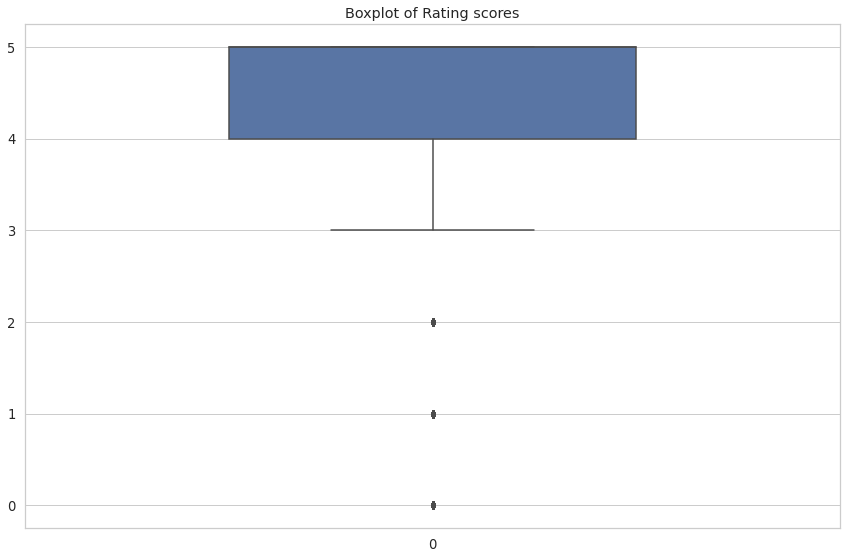

In [15]:
# Generating the figure.
plt.figure(figsize=(12, 8)) # Setting the figure size.
sns.set(style="whitegrid", font_scale=1.2) # Addind a white space on the back and adjustive font scale.
# Creates the boxplot
ax = sns.boxplot(data=ratings_column_pd['Rating'], width=0.5) # Boxplot, setting the width of the box to .5.
ax.set_title('Boxplot of Rating scores') # Add title to the figure.
plt.tight_layout() # Adjusts the layout
plt.show() # Shows the plot

The boxplot shows shows that most of values are located in the maximum values, but also points the score 0, 1 and 2 as outliers, this could be due to the fact that those values represents a small percentage of the total (approximately 7-8%). So based on IQR calculations are considering them as outliers.

- The values 1 and 2 will not be outliers, despite being a small amount they represent negative score reviews of the recipe;
- The value of 0 will be analysed in a later stage along with the writen review.

Despite the outliers considerations the values which represents the 1 and 2 score rating will remain in the dataset. This is because they are still a valid data point. Although, the score zeros will be analysed a little further.

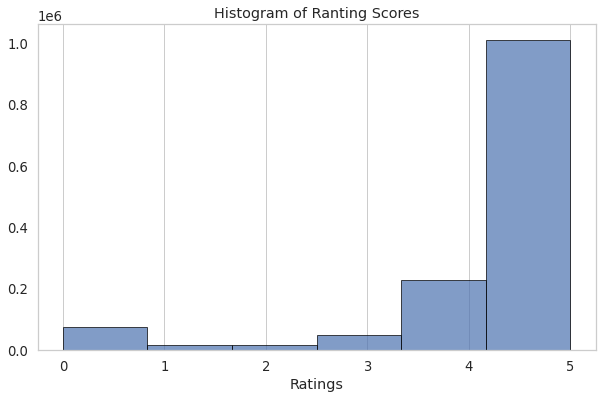

In [16]:
# Creating the figure for the histogram.
plt.figure(figsize=(10, 6))
# Plots the histogram, bins set at 6 because of the range of the value.
plt.hist(ratings_column_pd['Rating'], bins=6, edgecolor='black', alpha=0.7)
plt.title("Histogram of Ranting Scores") # Sets title.
plt.xlabel("Ratings") # Sets x label.
plt.xticks(range(6)) # Add ticks with range between 0 and 6.
plt.grid(axis='y') 
plt.show() # Display the histogram.

The histogram shows that the ratings scores data is highly left skewed. With most of its values located at the maximum.

- The score zero raised doubts if someone forgot to leave a score or if it is actually the worst score.

- Also, there are no notes about the score zero, so a manual check will be apply to check if there is a balance between the review and the score zero. The procedure will be done by looking at random samples (attempted multiple times with differend seed values), checking if the reviews truly represents a sentiment of a lowest score possible.

In [17]:
zero_reviews = df_reviews.filter(col("Rating") == 0)
sample_reviews = zero_reviews.sample(withReplacement=False, fraction=0.25, seed=70)
sample_reviews.select("Review").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Review                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

- According to last code (with many attempts using different seed numbers), the written reviews does not match the score zero given. Positives reviews such as, great recipe, its delicious . Therefore, the chosen option is to drop the 0 scores (anomalies), so it does not affects the analysis by introducing noise to it, increasing the consistency in the data.
- And since they are anomalies in the data, the rows with score of 0 will be dropped, also saving computational resources. 
<br><br><br>The next two codes will be used to drop (by using the method filter) and after printing the counts before and after the operation to check if it was correct. 

In [18]:
# Method filter to exclude the rows with Rating equal to zero.
df_reviews_no_zero = df_reviews.filter(df_reviews.Rating != 0)

In [19]:
# Counting observations before and after the exclusion and printing them for verification. 
original_count = df_reviews.count()
filtered_count = df_reviews_no_zero.count()
print(f"Original obs count: {original_count}")
print(f"After filter obs count: {filtered_count}")

Original obs count: 1401982
After filter obs count: 1325734


- After the drop, the observations reduced by 76248, which is the number of zero scores given (also provided at the frequency line of code). Therefore, the drop operation was sucessful.

### Next stage will be the text processing of the Review column, however only a few steps of the pre processing will be called before splitting the dataset to avoid data leakage.  The steps before dividing into traininig, validation and test are:

- Label definition; 
- Lowering case; 
- Removing punctuations and \r\n;

- First a column (label) will be created with positive, negative and neutral labels according to the rating score given by the reviewer. 

In [20]:
# Creates a new column 'label' based on rating values
df_reviews_no_zero = df_reviews_no_zero.withColumn("label", 
                   when(col("rating").isin([1, 2]), "negative")
                   .when(col("rating") == 3, "neutral")
                   .otherwise("positive")
                  )

# You can verify by showing a few records
df_reviews_no_zero.select("rating", "label").show()


+------+--------+
|rating|   label|
+------+--------+
|     5|positive|
|     4|positive|
|     2|negative|
|     5|positive|
|     5|positive|
|     4|positive|
|     5|positive|
|     5|positive|
|     5|positive|
|     4|positive|
|     5|positive|
|     5|positive|
|     1|negative|
|     5|positive|
|     4|positive|
|     1|negative|
|     5|positive|
|     5|positive|
|     3| neutral|
|     4|positive|
+------+--------+
only showing top 20 rows



According to the last cell, the label features was successfully created. Next, the dataset will be transformed into lower case letters.

In [21]:
# Creating a column named Review_lower to the dataframe in a lowercase version.
process_reviews = df_reviews_no_zero.withColumn("Review_lower", lower(col("Review")))

In [22]:
# Looks for any observation that the transformation did not work.
no_match = process_reviews.filter(lower(col("Review")) !=col("Review_lower")).count()

if no_match == 0:
    print("Transformation successful.")
else:
    print("There is/are rows that the transformation did not work.")

Transformation successful.


- After the transformation, a few statistical features will be generated for comparison purpose. 

In [23]:
# Displaying the characters length of the review_lowercase column
process_reviews = process_reviews.withColumn("rev_char_length", length(process_reviews["Review_lower"]))
process_reviews.select("rev_char_length").show()

+---------------+
|rev_char_length|
+---------------+
|             44|
|            102|
|             91|
|            119|
|             18|
|             38|
|            108|
|             26|
|            106|
|             48|
|            118|
|            182|
|             27|
|            167|
|            146|
|             10|
|            339|
|             83|
|             65|
|            225|
+---------------+
only showing top 20 rows



In [24]:
# Displaying statistical feature of the reviews character length. 
process_reviews.select("rev_char_length").describe().show()

+-------+------------------+
|summary|   rev_char_length|
+-------+------------------+
|  count|           1325734|
|   mean| 276.9054689703968|
| stddev|194.79580324070147|
|    min|                 0|
|    max|              8587|
+-------+------------------+



In [25]:
# Transforming to pandas dataframe for visualization purpose.
review_char_lengh_pd = process_reviews.select("rev_char_length").toPandas()

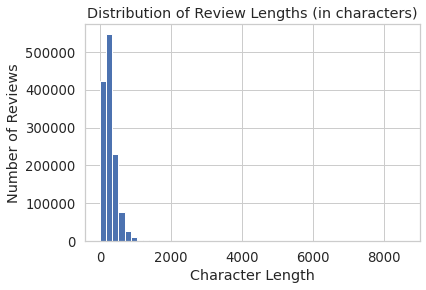

In [26]:
# Creating histogram for characters length
char_lengths = review_char_lengh_pd["rev_char_length"] # Data
char_lengths.hist(bins=50) # Generate histogram.
plt.xlabel("Character Length") # Adds label.
plt.ylabel("Number of Reviews") # Adds label.
plt.title("Distribution of Review Lengths (in characters)") # Adds title.
plt.show() # Shows the histogram.

- According to the character length histogram, the majority of reviews ranges between 0 and around 1500, but also showing that also has reviews with more than 6000 characters. 

Next pre processing stage is to remove punctuations and characters such as \r\n.

In [27]:
# Removing punctions of the Review_lowercase column.
process_reviews = process_reviews.withColumn("Review_no_punct", regexp_replace(col("Review_lower"), "[^a-zA-Z\s]", ""))

In [28]:
# Displays the rows of column before and after the removal of punctuations. 
process_reviews.select("Review_lower", "Review_no_punct").show(n=20, truncate=False)   

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Review_lower                                                                                                                                                                                                                                                                                                               

- The previous line of code shows that the removal of puctuations was successful. However, it shows special characters like \r\n, which will be removed in the following step.

In [29]:
# Removing \r\n.
process_reviews = process_reviews.withColumn("Review_no_punct2", regexp_replace(col("Review_no_punct"), "[\r\n]", ""))

In [30]:
process_reviews.select("Review_no_punct", "Review_no_punct2").show(n=20, truncate=False)  

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Review_no_punct                                                                                                                                                                                                                                                                                                                            |Review_no_punct2     

In [31]:
w_count = process_reviews.withColumn("word_count", size(split(process_reviews["Review_lower"], " ")))

w_count.select("word_count").describe().show()

+-------+-----------------+
|summary|       word_count|
+-------+-----------------+
|  count|          1325734|
|   mean|53.35392393949314|
| stddev|37.57547429823871|
|    min|                1|
|    max|             1184|
+-------+-----------------+



The last cell was called for statistical purpose before splitting the dataset into training, validation and test. 

<b> add the features </b>

### After a few steps of processing, the dataset will be split into three different sets, the training, validation and test. 

In [32]:
# Defining fractions to split the dataset.
train_fractions = {label: 0.6 for label in process_reviews.select("label").distinct().rdd.flatMap(lambda x: x).collect()}

# Creating a train set.
df_train = process_reviews.sampleBy("label", fractions=train_fractions, seed=42)

In [33]:
# Creates the 40% left set to be splitted between validation and test.
remaining_df = process_reviews.subtract(df_train)

In [34]:
# Defining fractions to split the dataset.
valid_fractions = {label: 0.5 for label in process_reviews.select("label").distinct().rdd.flatMap(lambda x: x).collect()}

# Creates the validation set from the 40%, using its franction of 
df_valid = remaining_df.sampleBy("label", fractions=valid_fractions, seed=42)

In [35]:
df_test = remaining_df.subtract(df_valid)

In [36]:
# Displaying the class distributions after the split using the stratified method.
df_train.groupBy("label").count().show()
df_valid.groupBy("label").count().show()
df_test.groupBy("label").count().show()

+--------+------+
|   label| count|
+--------+------+
|positive|745635|
| neutral| 30424|
|negative| 20526|
+--------+------+



2023-10-03 22:18:49,192 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-10-03 22:18:49,226 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-10-03 22:18:49,255 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-10-03 22:18:49,289 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+--------+------+
|   label| count|
+--------+------+
|positive|248220|
| neutral|  9876|
|negative|  6832|
+--------+------+



+--------+------+
|   label| count|
+--------+------+
|positive|247486|
| neutral|  9947|
|negative|  6788|
+--------+------+



In [37]:
# Calculating the distribution of scores and the three different classes.
# Placing the 1,2 to the negatives, 3 neutral and 4,5 positives.
class_counts = (
    df_train.withColumn(
    "Rating_class",
    when((df_train['Rating'] >= 1) & (df_train['Rating'] <= 2), "Negatives (1-2)")
    .when(df_train['Rating'] == 3, "Neutral (3)")
    .otherwise("Positives (4-5)"))
# Grouping the ratings into its class and using rdd to transform them into a dictionary which is easier to access in a query.
    .groupBy("Rating_class")
    .count()
    .rdd.collectAsMap())

# Calculates to total number of reviews.
total_reviews = sum(class_counts.values())
# Calculates the ratio.
Ratios = {k: v / total_reviews for k, v in class_counts.items()}
# Prints the percentages.
for Rating_class, ratio in Ratios.items():
    print(f"Rating Class {Rating_class}: {ratio*100:2f}%")

Rating Class Neutral (3): 3.819304%
Rating Class Negatives (1-2): 2.576749%
Rating Class Positives (4-5): 93.603947%


Through the last line of code, the train dataframe have:

- By far, the highest number of score given is the value of 5 (maximum);
- Lower scores (1 , 2) represents less than 3% of the total of ratings given and less than 4% for neutral scores (3); <b> important feature for next step.
- The imbalance between the positive classes are enourmous considering the others, and this potenlially could add bias into the sentiment analysis. To address this issue there are some options available to and a mixed between oversampling and undersampling will be performed after the dataframe is split into train and test. 

- Before tonekization, extracts the sets in a DF form where the X are the Reviews and y the labels.

In [38]:
# Extract as DataFrames, not Columns
X_train = df_train.select(["Review_no_punct2"])
y_train = df_train.select(["label"])

X_val = df_valid.select(["Review_no_punct2"])
y_val = df_valid.select(["label"])

X_test = df_test.select(["Review_no_punct2"])
y_test = df_test.select(["label"])

In [39]:
# Initialize a tokenizer
tokenizer = Tokenizer(inputCol="Review_no_punct2", outputCol="tokens")

# Tokenize X_train
X_train_token = tokenizer.transform(X_train)

# Tokenize X_val
X_val_token = tokenizer.transform(X_val)

# Tokenize X_test
X_test_token = tokenizer.transform(X_test)


- There are pre processing steps that could have been called before tokenization, such as removal of stop words, however in the Spark environment the command only removes when its separeted. Therefore pre processing steps will be performed also after the tokenization. 

In [42]:
# It "explodes" the tokens column to have one token per row.
X_train_token_exploded = X_train_token.select(explode("tokens").alias("words"))

# Groups individual by tokens and count their occurrences.
word_counts = X_train_token_exploded.groupBy("words").agg(count("words").alias("count"))

# Orders by count in descending order to see most frequent words at the top.
word_counts_ordered_train = word_counts.orderBy(desc("count"))

# Show the results.
word_counts_ordered_train.show()

+------+-------+
| words|  count|
+------+-------+
|      |1970835|
|     i|1867938|
|   the|1812699|
|   and|1398407|
|     a|1082303|
|    it| 965808|
|  this| 848003|
|    to| 829745|
|   for| 790991|
|    of| 685157|
|   was| 572014|
|recipe| 474370|
|    in| 394110|
|    my| 378208|
|  with| 378198|
|    is| 353257|
|  made| 337622|
|    so| 334438|
|  used| 299387|
|   but| 286445|
+------+-------+
only showing top 20 rows



- As shown in the previous cell that there are spaces being counted which does not have any meaning to the model. The removal of this character will be filtering out short tokens (less than 2), the reason for the number is that word like "no".

In [43]:
# UDF to filter out short tokens
filter_short_udf = udf(lambda tokens: [token for token in tokens if len(token) > 1], ArrayType(StringType()))

X_train = X_train_token.withColumn("filt_tokens", filter_short_udf(X_train_token["tokens"]))

In [44]:
X_val = X_val_token.withColumn("filt_tokens", filter_short_udf(X_val_token["tokens"]))
X_test = X_test_token.withColumn("filt_tokens", filter_short_udf(X_test_token["tokens"]))

#### Removing Stop Words

In [45]:
# Defines the stopword remover.
remover = StopWordsRemover(inputCol="filt_tokens", outputCol="tokens_no_stopwords")

# Removes stopwords from the training dataset.
X_train = remover.transform(X_train)

# Removes stopwords from the validation dataset.
X_val = remover.transform(X_val)

# Removes stopwords from the test dataset.
X_test = remover.transform(X_test)


## DO I REMOVE THE EMPTY TOKENS? 

In [ ]:
#token_reviews.filter(size(token_reviews["tokens_2"]) == 0).count()

In [ ]:
# Filter the empty token reviews
#empty_token_reviews = token_reviews.filter(size(token_reviews["tokens_2"]) == 0)

# Group by the 'Rating' column and count the number of reviews in each group
#result = empty_token_reviews.groupBy("Rating").agg({"Rating": "count"}).orderBy("Rating")

# Show the result
#result.show()


- After removing the stop words and filtering out short tokens, the number of observations in the review column with zero tokes increased from 4 to 327, which the amount for each score can be looked at the previous code.

The chosen solution for the empty rows after the transformation is to drop them, performed in the next line of code. 

In [ ]:
# Remove rows where the token list is empty
#non_empty_reviews = token_reviews.filter(size(token_reviews["tokens_2"]) > 0)

## IT HAS TO GO SOMEWHERE NOW....

The stage of text processing almost at the final stage, the descriptive statistical of the reviews suffered a big change. 
- Started with 1,401,982 rows and at this stage have 1,325,407, a reduction of 76,575.
- The mean of 53 reduced to 26, meaning that the average length of words in each review reduced more than 50%, a big decrease. 
- Standard Deviation, also reduced around 50%.
- The max length also slumped, from more than 1100 words it is now 639.  

- For computational resources (time consuming) only the training set (X_train) will be performed the word count and frequency, along with visualization. The next following line of codes will help identify the maximun words to be used during the padding stage.

In [46]:
# It "explodes" the tokens column to have one token per row.
X_train_exploded = X_train.select(explode("tokens_no_stopwords").alias("words"))

# Groups individual by tokens and count their occurrences.
word_counts = X_train_exploded.groupBy("words").agg(count("words").alias("count"))

# Orders by count in descending order to see most frequent words at the top.
word_counts_ordered = word_counts.orderBy(desc("count"))

# Show the results.
word_counts_ordered.show()

+---------+------+
|    words| count|
+---------+------+
|   recipe|474370|
|     made|337622|
|     used|299387|
|     make|240394|
|   thanks|238020|
|    great|218139|
|     good|209394|
|     easy|157983|
|     time|156962|
|    added|146700|
|   really|136392|
|     like|134479|
|      one|118986|
|delicious|117424|
|     also|116263|
|      use|110702|
|    sauce|110041|
|    loved|109929|
|    didnt|109893|
|   little|106978|
+---------+------+
only showing top 20 rows



# ADD LINE GRID!!!

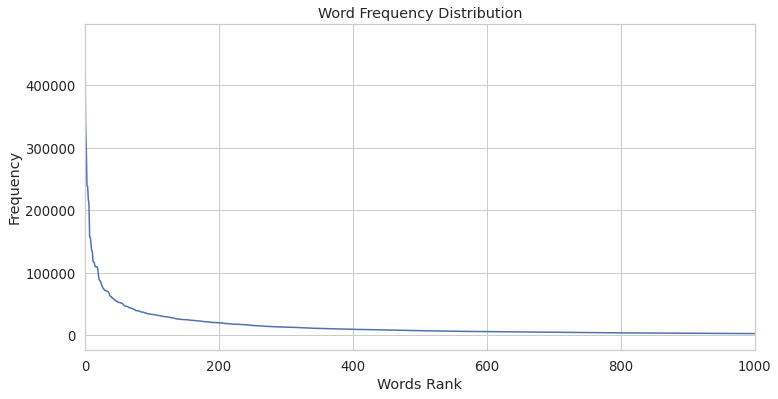

In [47]:
# Convert the word counts to pandas dataframe for visualization
word_counts_ordered = word_counts_ordered.toPandas()

# Plot the word frequencies
plt.figure(figsize=(12, 6))
plt.plot(word_counts_ordered['count'].values)  # this plots word counts in descending order
plt.xlabel('Words Rank')
# Set x-axis limit
plt.xlim(0, 1000)
plt.ylabel('Frequency')
plt.title('Word Frequency Distribution')
plt.show()

In [48]:
word_counts = (X_train.select(explode(col("tokens_no_stopwords")).alias("word"))
               .groupBy("word")
               .count()
               .orderBy(col("count").desc()))

# Compute total word occurrences
total_word_occurrences = word_counts.agg({"count": "sum"}).collect()[0][0]

# Compute occurrences of top N words
N = 600
top_N_word_occurrences = word_counts.limit(N).agg({"count": "sum"}).collect()[0][0]

# Compute the coverage
coverage = (top_N_word_occurrences / total_word_occurrences) * 100

print("Total word occurrences:", total_word_occurrences)
print(f"Occurrences of top {N} words:", top_N_word_occurrences)
print(f"Coverage of top {N} words: {coverage:.2f}%")


Total word occurrences: 20824449
Occurrences of top 600 words: 14785063
Coverage of top 600 words: 71.00%


In [49]:
import spacy
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

# Load spaCy model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"])

@udf(ArrayType(StringType()))
def lemmatize_udf(tokens):
    # Convert list of tokens to single string
    doc = nlp(" ".join(tokens))
    
    # Return list of lemmatized tokens
    return [token.lemma_ for token in doc]

# Apply the UDF
# Apply the UDF to all three datasets
X_train = X_train.withColumn("lemmatized_tokens", lemmatize_udf(X_train["tokens_no_stopwords"]))
X_val = X_val.withColumn("lemmatized_tokens", lemmatize_udf(X_val["tokens_no_stopwords"]))
X_test = X_test.withColumn("lemmatized_tokens", lemmatize_udf(X_test["tokens_no_stopwords"]))

In [50]:
X_train.select("tokens_no_stopwords", "lemmatized_tokens").show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tokens_no_stopwords                                                                                                                                                                                                                                                                                           |lemmatized_tokens                                                                                     

2023-10-03 22:52:46,781 WARN python.PythonUDFRunner: Detected deadlock while completing task 0.0 in stage 134 (TID 143): Attempting to kill Python Worker


- The previous code shows that the lemmatization was a success, words such as working became work, called is also call.

In [ ]:
aaa

In [ ]:
from pyspark.ml.feature import Word2Vec

# Step 1: Define the Word2Vec model
# The input column should be the column containing the lemmatized tokens
# The output column will be where the vectors are stored
# You can adjust the vectorSize and minCount parameters based on your data and requirements

word2Vec = Word2Vec(vectorSize=100, minCount=5, inputCol="lemmatized_tokens", outputCol="Review")

# Step 2: Train the Word2Vec model on the training set
model = word2Vec.fit(X_train)


In [ ]:
# Step 3: Use the trained model to transform all datasets
df_train = model.transform(X_train)
df_val = model.transform(X_val)
df_test = model.transform(X_test)



In [ ]:
from pyspark.ml.feature import Word2Vec

# Initialize word2vec model
word2vec = Word2Vec(vectorSize=100, minCount=5, inputCol="lemmatized_tokens", outputCol="word2vec_features")

# Fit the model on your data
word2vec_model = word2vec.fit(tokens_lemma)

# Transform the data to get word embeddings
df_reviews_w2v = word2vec_model.transform(tokens_lemma)


In the previous cells it was noticed that the ratio between the "sentiments" are quite imbalanced (the positive one having more than 93%). Thus, due to this a stratified spliting will be applied, a same distribution as the original dataset will be applied to the spliting datasets, training, validation and test.  

In [ ]:
df_reviews_w2v.columns

# ADD PADDING

In [ ]:
from keras.preprocessing.sequence import pad_sequences

# `sequences` is a list of lists, where each inner list is a sequence of word indices.
padded_sequences = pad_sequences(sequences, padding='post')


As observed in previous cells, the gap ratio between the classes are large. Therefore, a few techniques will be combined to reduce the imbalaced between positive (93.63%), negative (2.58%) and neutral (3.79).<br><br> 
The first technique is the oversampling, increasing the size of the negative and neutral sample. It is worthy mentioning that this may cause overfiting, because it will increase by copying the data that already has.<b> WRITE THE AMOUNT OF THE INCREASE (DOUBLE TRIPLE...), NEED TO EXPERIMENT BASED ON RESULTS OF THE MODEL.</b><br><br>
The second is to undersample the positive side (93.63%) and it will be reduced by <b> SAME APPLY HERE AS THE PREVIOUS ONE.</b> One of the downfalls is the lost of information by reducing the sample.<br><br>
The last one is to apply class weights, <b>CHECK IF ITS GONNA BE SURE</b>, because even after the over and undersampling the imbalance is still present but not as large as the original.

In [ ]:
# Separate out different classes from the training dataset
positives = train_df.filter(col("label") == 'positive')
negatives = train_df.filter(col("label") == 'negative')
neutrals = train_df.filter(col("label") == 'neutral')

# Define oversampling factors
negative_oversample_factor = 2.0  # Double the negative samples
neutral_oversample_factor = 1.5   # 1.5 times the neutral samples

oversampled_negatives = negatives.sample(withReplacement=True, fraction=negative_oversample_factor)
oversampled_neutrals = neutrals.sample(withReplacement=True, fraction=neutral_oversample_factor)

# Undersample the majority class
undersample_factor = 0.25  # Reducing by 25%
undersampled_positives = positives.sample(withReplacement=False, fraction=undersample_factor)

# Combine the samples back
balanced_train_df = undersampled_positives.unionAll(oversampled_negatives).unionAll(oversampled_neutrals)

# Calculate class weights for the balanced dataset
total_count = balanced_train_df.count()
positive_weight = total_count / undersampled_positives.count()
negative_weight = total_count / (negatives.count() * negative_oversample_factor) # can be tweaked (1.5, 2, 2.5)
neutral_weight = total_count / (neutrals.count() * neutral_oversample_factor) # can be tweaked (1.5, 2, 2.5)

# Normalize weights
normalizing_factor = positive_weight + negative_weight + neutral_weight
positive_weight /= normalizing_factor
negative_weight /= normalizing_factor
neutral_weight /= normalizing_factor

class_weights = {
    'positive': positive_weight,
    'negative': negative_weight,
    'neutral': neutral_weight}

In [ ]:
# Count instances for each class
positives = balanced_train_df.filter(col("label") == 'positive').count()
negatives = balanced_train_df.filter(col("label") == 'negative').count()
neutrals = balanced_train_df.filter(col("label") == 'neutral').count()

total_count = positives + negatives + neutrals

# Calculate proportions for each class
positive_ratio = (positives / total_count) * 100
negative_ratio = (negatives / total_count) * 100
neutral_ratio = (neutrals / total_count) * 100

print(f"Rating Class Positives (4-5): {positive_ratio:.2f}%")
print(f"Rating Class Negatives (1-2): {negative_ratio:.2f}%")
print(f"Rating Class Neutral (3): {neutral_ratio:.2f}%")
